# Introduction

This notebook explores Bayesian techniques for statistical arbitrage, with a focus on modelling mean-reversion dynamics. By using Bayesian inference, we capture uncertainty in key parameters and enable probabilistically grounded, dynamic decision-making.

Note: The data and models here are illustrative and not production-ready. The goal is to compare traditional statistical arbitrage methods with a Bayesian approach.

I chose Apple and Microsoft for illustrative purposes since they belong to the same geographical and industrial categories, though in a production model pair selection may be dynamic in time and inspect less well-studied stocks, and perhaps focus on pairs with a stronger theoretical basis for cointegration (such as A-class and B-class shares of the same company).

# Imports

In [9]:
# point nb up to allow import of custom modules from parent directory
import sys
sys.path.append('../')
# import custom modules
from utils.models.regression import compute_rolling_spread_and_z, estimate_rolling_beta
from utils.helpers.stats import rolling_adf, rolling_half_life
from utils.backtest.backtest import backtest
from utils.helpers.logistics import describe_to_markdown

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd

import pymc as pm
import arviz as az

In [2]:
window = 60  # hyperparameter for rolling averages

## Load & Visualise Data

NB Bayesian beta estimate calculations performed elsewhere (time-consuming).

In [3]:
prices = pd.read_csv('../data/data_sample.csv', index_col=0, parse_dates=True)
rolling_beta_bayes = pd.read_csv('../data/bayesian_betas_extracted.csv', index_col=0, parse_dates=True)


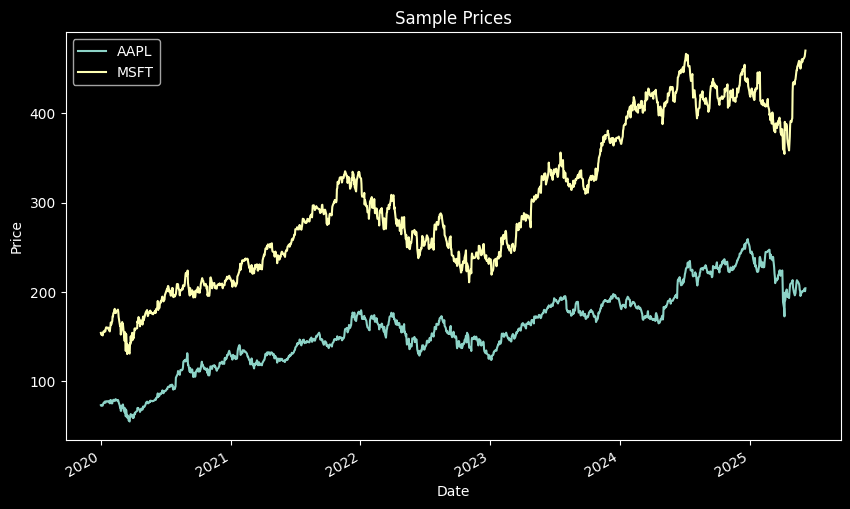

In [5]:
prices[['AAPL', 'MSFT']].plot(figsize=(10, 6))
plt.title('Sample Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Estimate Rolling Beta: Frequentist vs Bayesian

The chart below shows that the Bayesian estimate of $\beta$ is much smoother than its classical counterpart. By updating a prior with new data, the Bayesian approach acts as a form of regularisation, preventing the model from overreacting to short-term noise or temporary statistical quirks. This helps isolate more persistent relationships — potentially reflecting genuine economic mechanisms or exploitable market inefficiencies — rather than spurious shifts. (Of course a trading model aiming to capture short-lived signals would need a different approach.)

### Bayesian Linear Regression Model

We model the relationship between two asset price series $X_t$ and $Y_t$ as:

$$
Y_t = \alpha + \beta X_t + \epsilon_t
$$

where the residuals are assumed Gaussian:

$$
\epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

**Parameters**

$\alpha$ is the intercept term — baseline level of $Y$ when $X=0$.

$\beta$ is the slope coefficient — measures the cointegration relationship strength.

$\sigma$ is the noise standard deviation — captures unexplained variability.

In the frequentist model, $\beta$ is estimated as a point estimate that minimises the sum of squared errors (e.g., using the normal equation).

In contrast, the Bayesian model treats $\beta$ as a random variable with a prior distribution, allowing us to capture uncertainty about its true value. Our model specifies a likelihood function to relate observed data to parameters:

$$
\
y_i \sim \mathcal{N}(\alpha + \beta x_i, \, \sigma^2)
\
$$

where:

- $\alpha$ is the intercept,
- $\beta$ is the slope (cointegration coefficient),
- $\sigma$ is the standard deviation of noise.

Bayesian inference updates the prior beliefs about $\alpha$, $\beta$, and $\sigma$ using observed data to obtain the posterior distributions, which reflect our updated uncertainty after seeing the data.


**Priors:**

$$
\alpha \sim \mathcal{N}(0, 1)
$$

$$
\beta \sim \mathcal{N}(0.5, 1)
$$

$$
\sigma \sim \text{HalfNormal}(1)
$$


### Bayesian Priors

- $\alpha \sim \mathcal{N}(0, 1)$  
  *Intercept prior: centered at 0, reflecting no expected outperformance.*

- $\beta \sim \mathcal{N}(0.5, 1)$  
  *Slope (cointegration coefficient) prior: centered at 0.5, expressing belief in positive cointegration but allowing uncertainty.*

- $\sigma_y \sim \text{HalfNormal}(1)$  
  *Observation noise (spread volatility) prior: positive-only, with scale 1.*

## Results

| Metric | Classical | Bayesian |
|--------|-----------|----------|
| Count | 1305.0 | 1305.0 |
| Mean | 1.069 | 1.895 |
| Std | 0.751 | 0.19 |
| Min | -1.555 | 1.612 |
| 25% | 0.602 | 1.76 |
| 50% | 1.057 | 1.83 |
| 75% | 1.621 | 1.975 |
| Max | 2.829 | 2.363 |

In [10]:
x = prices['AAPL']
y = prices['MSFT']
betas_classical = estimate_rolling_beta(x, y, window)

/tmp/ipykernel_22904/140055372.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(rolling_beta_bayes, label='Bayesian')


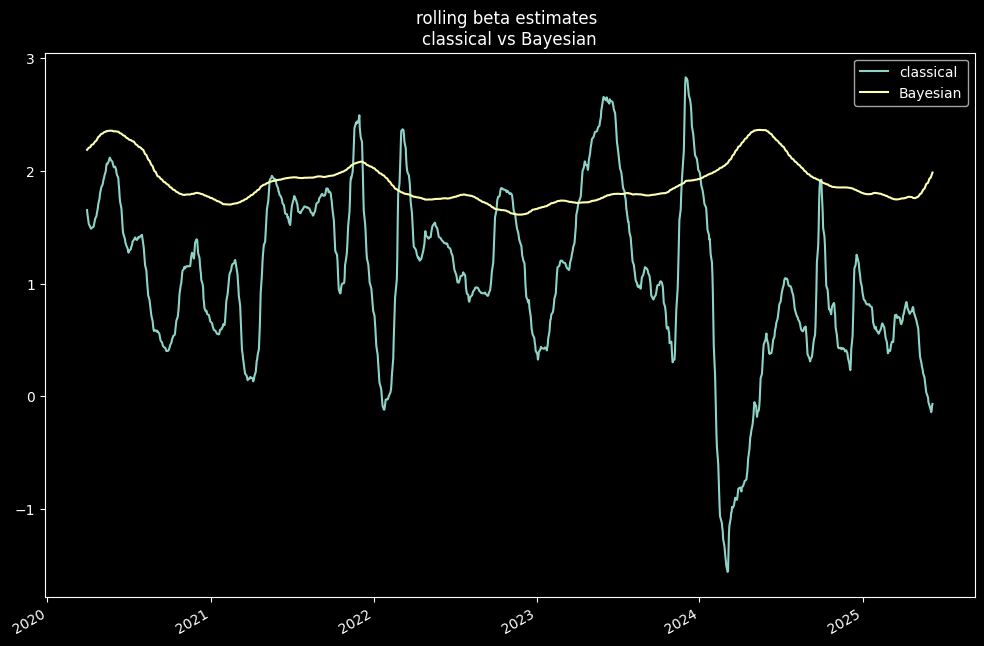

In [11]:
plt.figure(figsize=(12,8))
plt.title('rolling beta estimates \nclassical vs Bayesian')
betas_classical.plot(label='classical')
plt.plot(rolling_beta_bayes, label='Bayesian')
plt.legend()
plt.show()

# Signal comparison

We compare the classical and Bayesian versions of the mean-reversion signal using four key diagnostics over time:

- Z-score of the spread
- ADF test p-value for stationarity
- Half-life of mean reversion
- Rolling standard deviation of the z-score (volatility)

These diagnostics help us assess both the strength and stability of the trading signal.

Key Observations:

- The Bayesian z-score tends to be smoother and more persistent (typically between ±2, compared with ±4 for frequentist), reflecting the tighter, more regularised beta estimates.
- ADF p-values vary more erratically under the classical model, which may lead to spurious regime shifts. Bayesian z-scores typically generate more stable ADF results.
- The half-life of mean reversion is less volatile in the Bayesian case, suggesting more reliable reversion dynamics.
- The z-score standard deviation is lower for the Bayesian signal, which may reduce the risk of whipsaw trades and improve trade filtering.

These differences can affect both signal quality and trade timing, which is explored further in the backtest comparison. They can also be used in regime filtering.

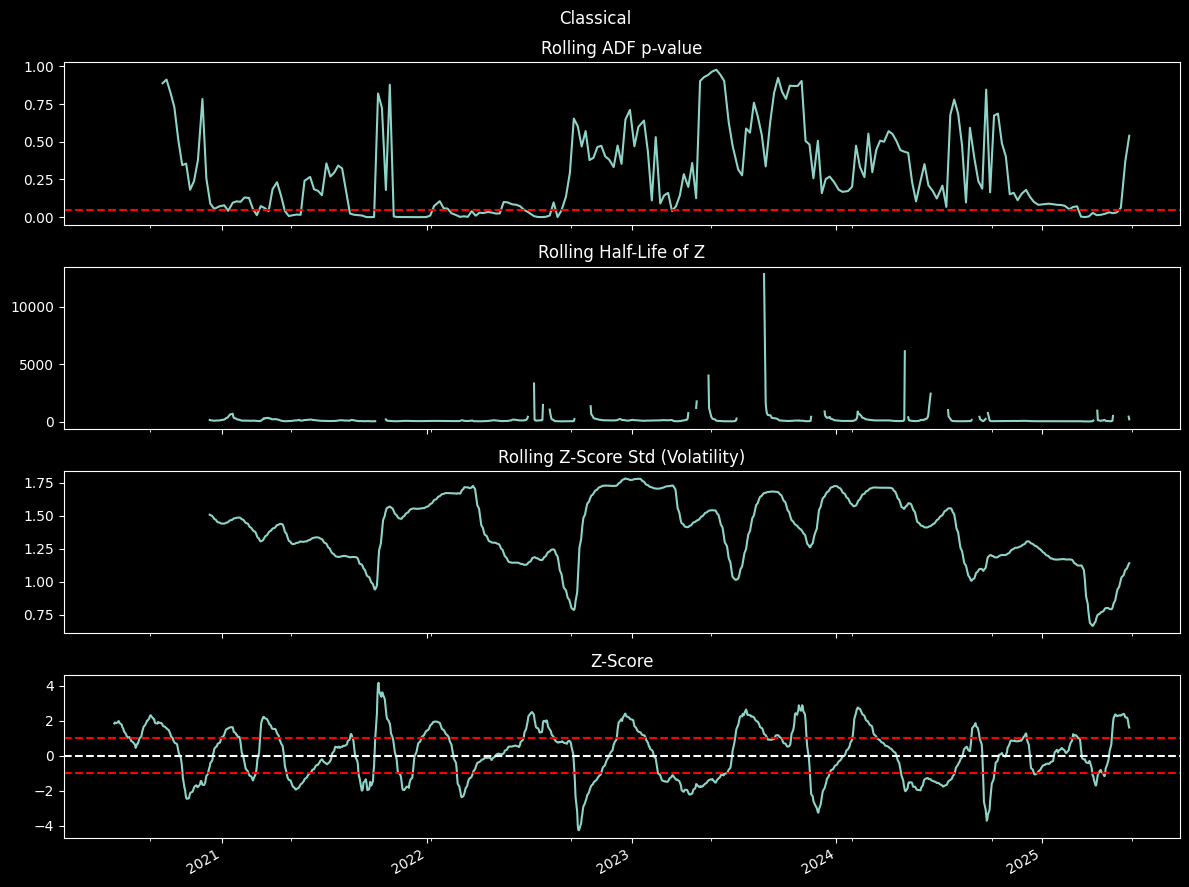

In [7]:
### Signal

log_prices = np.log(prices)
X = log_prices['AAPL']
Y = log_prices['MSFT']

# 1. Rolling beta, spread and z-score
spread, z = compute_rolling_spread_and_z(X, Y, None, window)

# 2. Rolling diagnostics
adf_df = rolling_adf(spread.dropna(), window=120)
hl_df = rolling_half_life(z.dropna(), window=120)
z_std = z.rolling(120).std().dropna()

# 3. Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Classical')

z.plot(ax=axs[3], title='Z-Score')
axs[3].axhline(0, color='white', linestyle='--')
axs[3].axhline(1, color='red', linestyle='--')
axs[3].axhline(-1, color='red', linestyle='--')

adf_df['p_value'].plot(ax=axs[0], title='Rolling ADF p-value')
axs[0].axhline(0.05, color='red', linestyle='--')

hl_df['half_life'].plot(ax=axs[1], title='Rolling Half-Life of Z')
z_std.plot(ax=axs[2], title='Rolling Z-Score Std (Volatility)')

plt.tight_layout()
plt.show()


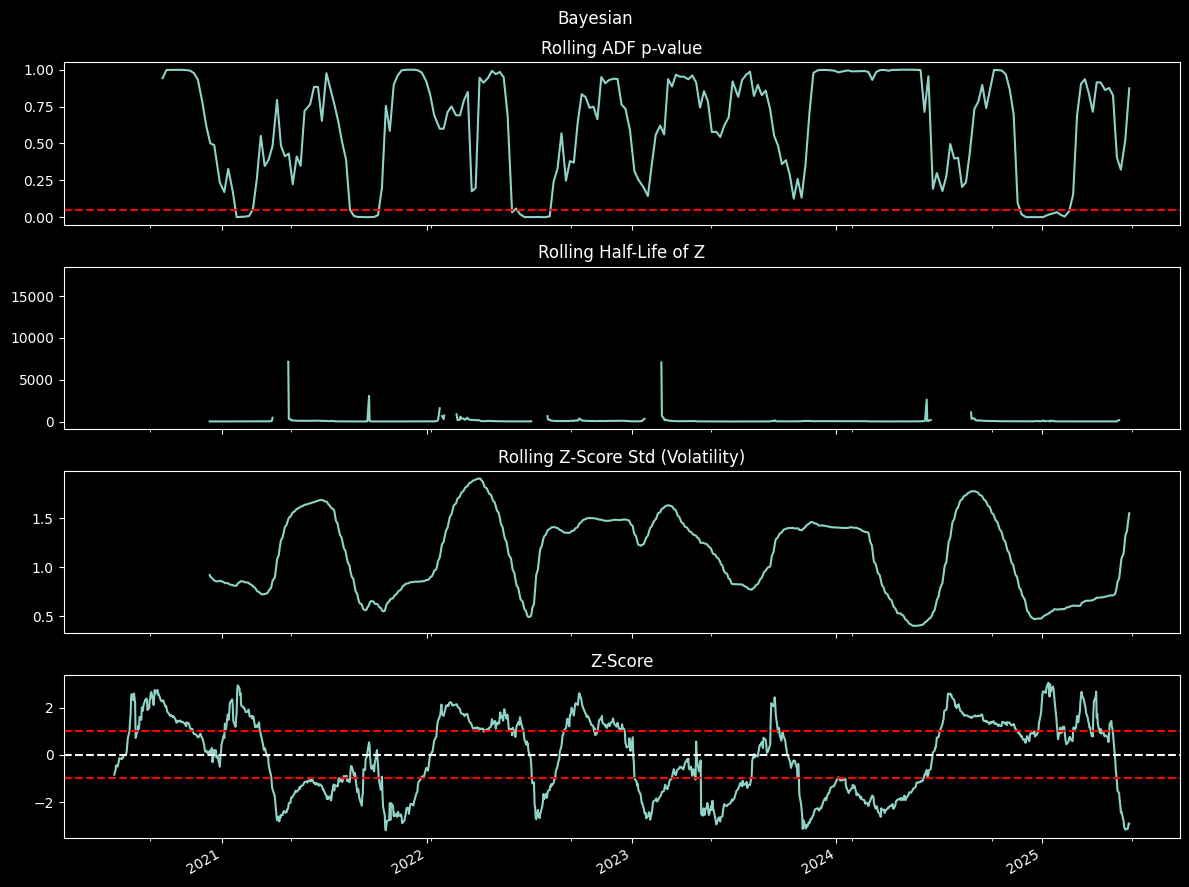

In [8]:
### Bayesian Signal

### Signal

log_prices = np.log(prices)
X = log_prices['AAPL']
Y = log_prices['MSFT']

# 1. Rolling beta, spread and z-score
spread_bayes, z_bayes = compute_rolling_spread_and_z(X, Y, rolling_beta_bayes, window)

# 2. Rolling diagnostics
adf_df_bayes = rolling_adf(spread_bayes.dropna(), window=120)
hl_df_bayes = rolling_half_life(z_bayes.dropna(), window=120)
z_std_bayes = z_bayes.rolling(120).std().dropna()

# 3. Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Bayesian')

z_bayes.plot(ax=axs[3], title='Z-Score')
axs[3].axhline(0, color='white', linestyle='--')
axs[3].axhline(1, color='red', linestyle='--')
axs[3].axhline(-1, color='red', linestyle='--')

adf_df_bayes['p_value'].plot(ax=axs[0], title='Rolling ADF p-value')
axs[0].axhline(0.05, color='red', linestyle='--')

hl_df_bayes['half_life'].plot(ax=axs[1], title='Rolling Half-Life of Z')
z_std_bayes.plot(ax=axs[2], title='Rolling Z-Score Std (Volatility)')

plt.tight_layout()
plt.show()


# Backtest Comparison
A basic prototype pairs-trading strategy on this pair loses money even before accounting for transaction costs (see charts below). Interestingly, simply replacing the classical estimate of the cointegration coefficient with a Bayesian estimate is enough to flip the performance — the strategy becomes profitable.

This suggests that Bayesian inference, by regularising parameter estimation and smoothing the signal, can improve performance even in challenging or unfavourable conditions.

- The only change was replacing the frequentist estimate of β with a Bayesian posterior mean.
- Everything else — signal construction, thresholds, entry/exit logic — remained identical.
- The classical approach loses money, the Bayesian makes money.

### Trading logic
Enter a short/long position when the z-score of the spread exceeds ±1:
- enter short if z>1,
- enter long if z<−1,
- exit position at 0.

In [ ]:
NAV_free_bayes, NAV_tc_bayes = backtest(prices,
             window = window,
            ticker_AAPL = 'AAPL',
            ticker_MSFT = 'MSFT',
            use_log_prx=False,
            transaction_cost = 0.001,  # 10 bps per trade,
            use_rtns = False,  # use returns instead of prices for backtest (default: True, use returns
            beta_z_spread_window=60,
            rolling_beta=rolling_beta_bayes,
            adf_window=120,
            hl_window=120,
            z_window=60,
            adf_threshold=0.05,
            min_half_life=2,
            max_half_life=30,
            max_z_std=2.0,
            step=1,
            regime_filter=False  # if True, apply regime filter
    )

In [ ]:
NAV_free_classical, NAV_tc_classical = backtest(prices,
             window = window,
            ticker_AAPL = 'AAPL',
            ticker_MSFT = 'MSFT',
            use_log_prx=False,
            transaction_cost = 0.001,  # 10 bps per trade,
            use_rtns = False,  # use returns instead of prices for backtest (default: True, use returns
            beta_z_spread_window=60,
            rolling_beta=None,
            adf_window=120,
            hl_window=120,
            z_window=60,
            adf_threshold=0.05,
            min_half_life=2,
            max_half_life=30,
            max_z_std=2.0,
            step=1,
            regime_filter=False  # if True, apply regime filter
    )

## Results

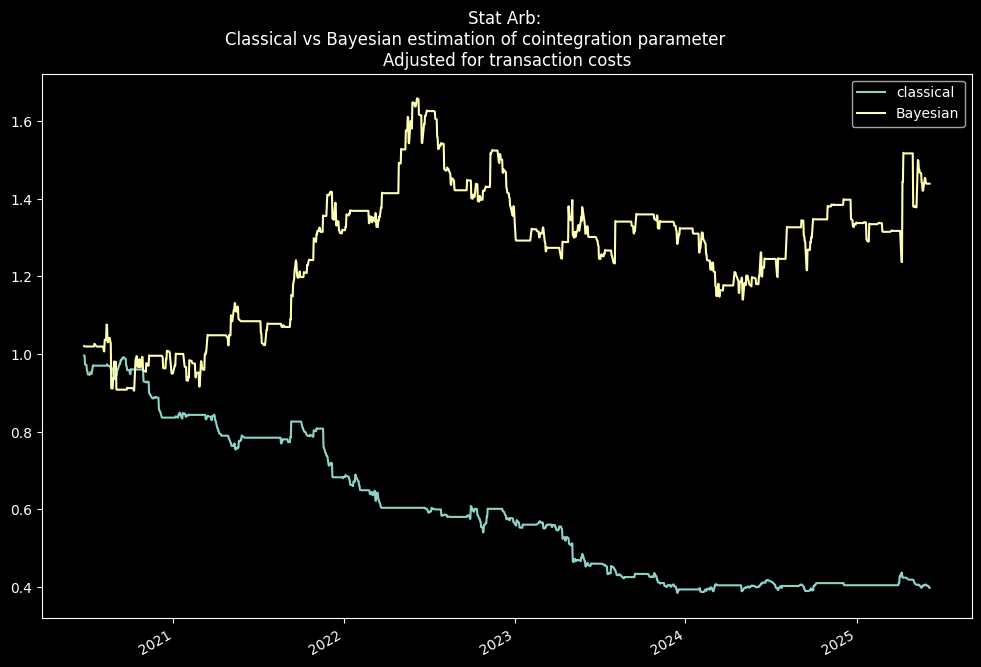

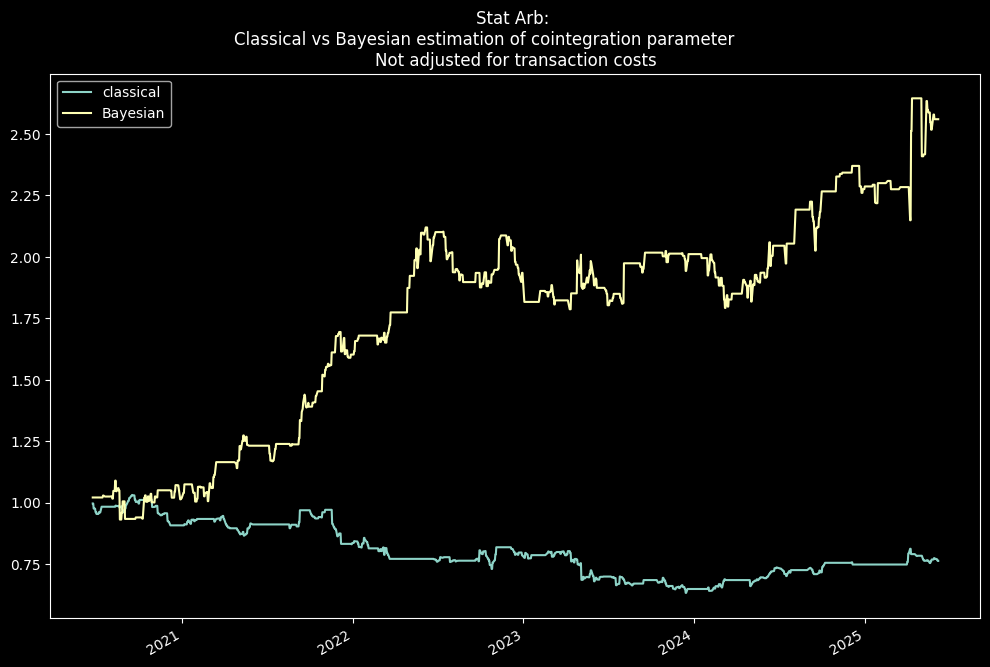

In [3]:
plt.figure(figsize=(12,8))
plt.title('Stat Arb: \nClassical vs Bayesian estimation of cointegration parameter ' \
'           \nAdjusted for transaction costs')
NAV_tc_classical.plot(label='classical')
NAV_tc_bayes.plot(label='Bayesian')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title('Stat Arb: \nClassical vs Bayesian estimation of cointegration parameter ' \
'           \nNot adjusted for transaction costs')
NAV_free_classical.plot(label='classical')
NAV_free_bayes.plot(label='Bayesian')
plt.legend()
plt.show()

# Ideas for future work (not implemented here)

There are lots of ways to Bayesianise statistical arbitrage. We began with the **cointegration relationship**.

1. cointegration parameter, beta
2. spread prediction: predictive distribution with credible intervals instead of points
3. regime shifts: Bayesian change point detection
4. mean-reversion signals: probability that abs(spread) > threshold
5. execution logic: use posterior volatility for risk-weighting

There are lots of ways to explore improving the Bayesianisation of estimating beta, namely choice of priors and likelihood model, which could be informed by data.